## Capstone project 

### Where to start a Sushi restaurant in Calgary, Alberta ?

#### About Calgary 
- Calgary is a city in the western Canadian province of Alberta, Canada
- 80 km east of the Canadian Rockies.
- Biggest city in Alberta and the second largest in western Canada after only Vancouver
- Calgary the most livable city in North America in both 2018 and 2019
- The Calgary Metropolitan Region is home to Canada's second-highest number of corporate head offices among the country's 800 largest corporations.
- In 2015 Calgary had the highest number of millionaires per capita of any major Canadian city. 
- In 1988 it became the first Canadian city to host the Winter Olympic Games.
- Given the diverse socio-economic and demographic nature of the city, starting a restaurant here might be a proposition that several business owners might consider. And what if, It is a Japanese Sushi restaurant?

### Business problem:

#### IDENTIFY THE BEST NEIGHBOURHOOD, IN THE CITY OF CALGARY, TO START A JAPANESE SUSHI RESTAURANT


In [1]:
import pandas as pd
import numpy as np

import requests
import json
from re import sub

import geocoder # import geocoder

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#!pip install folium
import folium # map rendering library

In [2]:
pd.set_option('display.max_rows', None)

### 1. Collect the data

#### 1.1 Community and area

In [3]:
# Get the community and area from wiki
wiki = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Calgary'
wiki_page = requests.get(wiki)

areaDF = pd.read_html(wiki_page.content, header = 0)[0]
areaDF = areaDF[['Name[10]','Area(km2)[11]']]
areaDF.columns = ['Community','Area']
#calDF = calDF.dropna().reset_index(drop=True)

# Remvoe the last row 
areaDF = areaDF[:-1]

# revise some commnucity name for consistency
areaDF.replace({'Community': {'Albert Park/Radisson Heights':'Albert Park / Radisson Heights','CFB Lincoln Park PMQ':'CFB Lincoln Park','Douglasdale/Glen':'Douglasdale / Douglas Glen','Penbrooke Meadows':'Penbrooke','St. Andrews Heights':'St Andrews Heights'}}, inplace=True)

areaDF.head(10)


,Community,Area
0,Abbeydale,1.7
1,Acadia,3.9
2,Albert Park / Radisson Heights,2.5
3,Altadore,2.9
4,Alyth/Bonnybrook,3.8
5,Applewood Park,1.6
6,Arbour Lake,4.4
7,Aspen Woods,3.8
8,Auburn Bay,4.5
9,Aurora Business Park,2.4


#### 1.2 Community demographics

In [4]:
# Get the community demographics
wiki = 'https://great-news.ca/demographics/'
wiki_page = requests.get(wiki)

calDF = pd.read_html(wiki_page.content, header = 0)[0]
#calDF = calDF.dropna().reset_index(drop=True)
calDF = calDF[['Community', 'Median Household Income', 'Population 2014']]
calDF.columns = ['Community', 'Median Household Income','Population']

# clen up a bit
calDF['Median Household Income'] = calDF['Median Household Income'].apply(lambda x: float(sub(r'[^\d.]', '', x)))

calDF.head(10)

,Community,Median Household Income,Population
0,Abbeydale,55345.0,6071
1,Acadia,46089.0,10969
2,Albert Park / Radisson Heights,38019.0,6529
3,Altadore,53786.0,9518
4,Applewood Park,65724.0,6864
5,Arbour Lake,70590.0,10987
6,Aspen Woods,133939.0,7496
7,Auburn Bay,84350.0,11127
8,Banff Trail,49996.0,4204
9,Bankview,32474.0,5416


In [5]:
calDF = calDF.merge(areaDF, on='Community', how='left')

# add population density
calDF['PopulationDensity'] = calDF['Population']/calDF['Area']

calDF.head(10)

,Community,Median Household Income,Population,Area,PopulationDensity
0,Abbeydale,55345.0,6071,1.7,3571.176471
1,Acadia,46089.0,10969,3.9,2812.564103
2,Albert Park / Radisson Heights,38019.0,6529,2.5,2611.600000
3,Altadore,53786.0,9518,2.9,3282.068966
4,Applewood Park,65724.0,6864,1.6,4290.000000
5,Arbour Lake,70590.0,10987,4.4,2497.045455
6,Aspen Woods,133939.0,7496,3.8,1972.631579
7,Auburn Bay,84350.0,11127,4.5,2472.666667
8,Banff Trail,49996.0,4204,1.5,2802.666667
9,Bankview,32474.0,5416,0.7,7737.142857


In [6]:
len(calDF.Community.unique())

180

In [7]:
calDF.isnull().sum()

Community                  0
Median Household Income    0
Population                 0
Area                       0
PopulationDensity          0
dtype: int64

In [8]:
calDF.isin([0]).sum()

Community                  0
Median Household Income    0
Population                 0
Area                       0
PopulationDensity          0
dtype: int64

#### 1.3 Get the geo data

In [9]:
import geocoder # import geocoder

geoList=[]

for neigh in calDF['Community']:
    g = geocoder.arcgis('{}, Calgary, Alberta'.format(neigh))
    #print(neigh, g.latlng)
    while (g.latlng is None):
        g = geocoder.arcgis('{}, Calgary, Alberta'.format(neigh))
        #print(neigh, g.latlng)
    geoList.append([neigh,g.latlng[0],g.latlng[1]])
geoDF = pd.DataFrame(geoList, columns=['Community','Latitude','Longitude'])
geoDF.head()

,Community,Latitude,Longitude
0,Abbeydale,51.05976,-113.92546
1,Acadia,50.97227,-114.05882
2,Albert Park / Radisson Heights,51.04200,-113.99683
3,Altadore,51.01601,-114.10558
4,Applewood Park,51.04544,-113.92513


In [10]:
calDF = calDF.merge(geoDF, on='Community', how='inner')
calDF.head(10)

,Community,Median Household Income,Population,Area,PopulationDensity,Latitude,Longitude
0,Abbeydale,55345.0,6071,1.7,3571.176471,51.05976,-113.92546
1,Acadia,46089.0,10969,3.9,2812.564103,50.97227,-114.05882
2,Albert Park / Radisson Heights,38019.0,6529,2.5,2611.600000,51.04200,-113.99683
3,Altadore,53786.0,9518,2.9,3282.068966,51.01601,-114.10558
4,Applewood Park,65724.0,6864,1.6,4290.000000,51.04544,-113.92513
5,Arbour Lake,70590.0,10987,4.4,2497.045455,51.13364,-114.20307
6,Aspen Woods,133939.0,7496,3.8,1972.631579,51.04519,-114.21160
7,Auburn Bay,84350.0,11127,4.5,2472.666667,50.88976,-113.96397
8,Banff Trail,49996.0,4204,1.5,2802.666667,51.07472,-114.11297
9,Bankview,32474.0,5416,0.7,7737.142857,51.03412,-114.10044


### 2. Explore the food venues of Calgary neighborhood

In [1]:
CLIENT_ID = 'EEIQ5XSNDRYW4TIEDPIVMXNFL4XDBU0KZS5NV1G10V1Q0OZ4' # your Foursquare ID
CLIENT_SECRET = 'GNHJRL0WNPGKOUPPVZNOABAL41G2U0NSFG2OMMLFUJABHR30' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
SECTION = 'food'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: EEIQ5XSNDRYW4TIEDPIVMXNFL4XDBU0KZS5NV1G10V1Q0OZ4
CLIENT_SECRET:GNHJRL0WNPGKOUPPVZNOABAL41G2U0NSFG2OMMLFUJABHR30


In [12]:

def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            SECTION,
            LIMIT)
            
        # make the GET request
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print("{} has total {} food venues".format( name,len(results)));
        #data = requests.get(url).json()
        #with open('result.json', 'w') as outfile:
        #    json.dump(data, outfile)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# get all the venues in Calgary residential 
calVenues = getNearbyVenues(names=calDF['Community'],
                                   latitudes=calDF['Latitude'],
                                   longitudes=calDF['Longitude']
                                  )
calVenues.head(10)


Abbeydale has total 12 food venues
Acadia has total 48 food venues
Albert Park / Radisson Heights has total 26 food venues
Altadore has total 19 food venues
Applewood Park has total 8 food venues
Arbour Lake has total 31 food venues
Aspen Woods has total 11 food venues
Auburn Bay has total 18 food venues
Banff Trail has total 34 food venues
Bankview has total 78 food venues
Bayview has total 9 food venues
Beddington Heights has total 17 food venues
Bel-Aire has total 38 food venues
Beltline has total 100 food venues
Bonavista Downs has total 11 food venues
Bowness has total 9 food venues
Braeside has total 11 food venues
Brentwood has total 18 food venues
Bridgeland/Riverside has total 64 food venues
Bridlewood has total 11 food venues
Britannia has total 13 food venues
Cambrian Heights has total 12 food venues
Canyon Meadows has total 15 food venues
Capitol Hill has total 35 food venues
Castleridge has total 29 food venues
Cedarbrae has total 8 food venues
CFB Currie has total 100 foo

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbeydale,51.05976,-113.92546,A&W,51.068291,-113.933571,Fast Food Restaurant
1,Abbeydale,51.05976,-113.92546,Atlas Pizza and Sports Bar,51.052481,-113.941859,Pizza Place
2,Abbeydale,51.05976,-113.92546,Subway,51.059239,-113.934423,Sandwich Place
3,Abbeydale,51.05976,-113.92546,Subway,51.069623,-113.932907,Sandwich Place
4,Abbeydale,51.05976,-113.92546,Subway,51.052786,-113.942449,Sandwich Place
5,Abbeydale,51.05976,-113.92546,Barrio Fiesta,51.052695,-113.935544,Filipino Restaurant
6,Abbeydale,51.05976,-113.92546,Mely's Bakery and Café,51.052672,-113.936031,Café
7,Abbeydale,51.05976,-113.92546,TNK Vietnamese Restaurant,51.069105,-113.933097,Vietnamese Restaurant
8,Abbeydale,51.05976,-113.92546,Wasim's Donair And Pizza,51.069021,-113.933791,Pizza Place
9,Abbeydale,51.05976,-113.92546,Green Olive,51.069488,-113.934406,Italian Restaurant


In [14]:
calVenues.shape

(4415, 7)

In [15]:
print('There are {} uniques categories.'.format(len(calVenues['Venue Category'].unique())))

There are 80 uniques categories.


#### Food Venue distribution per category

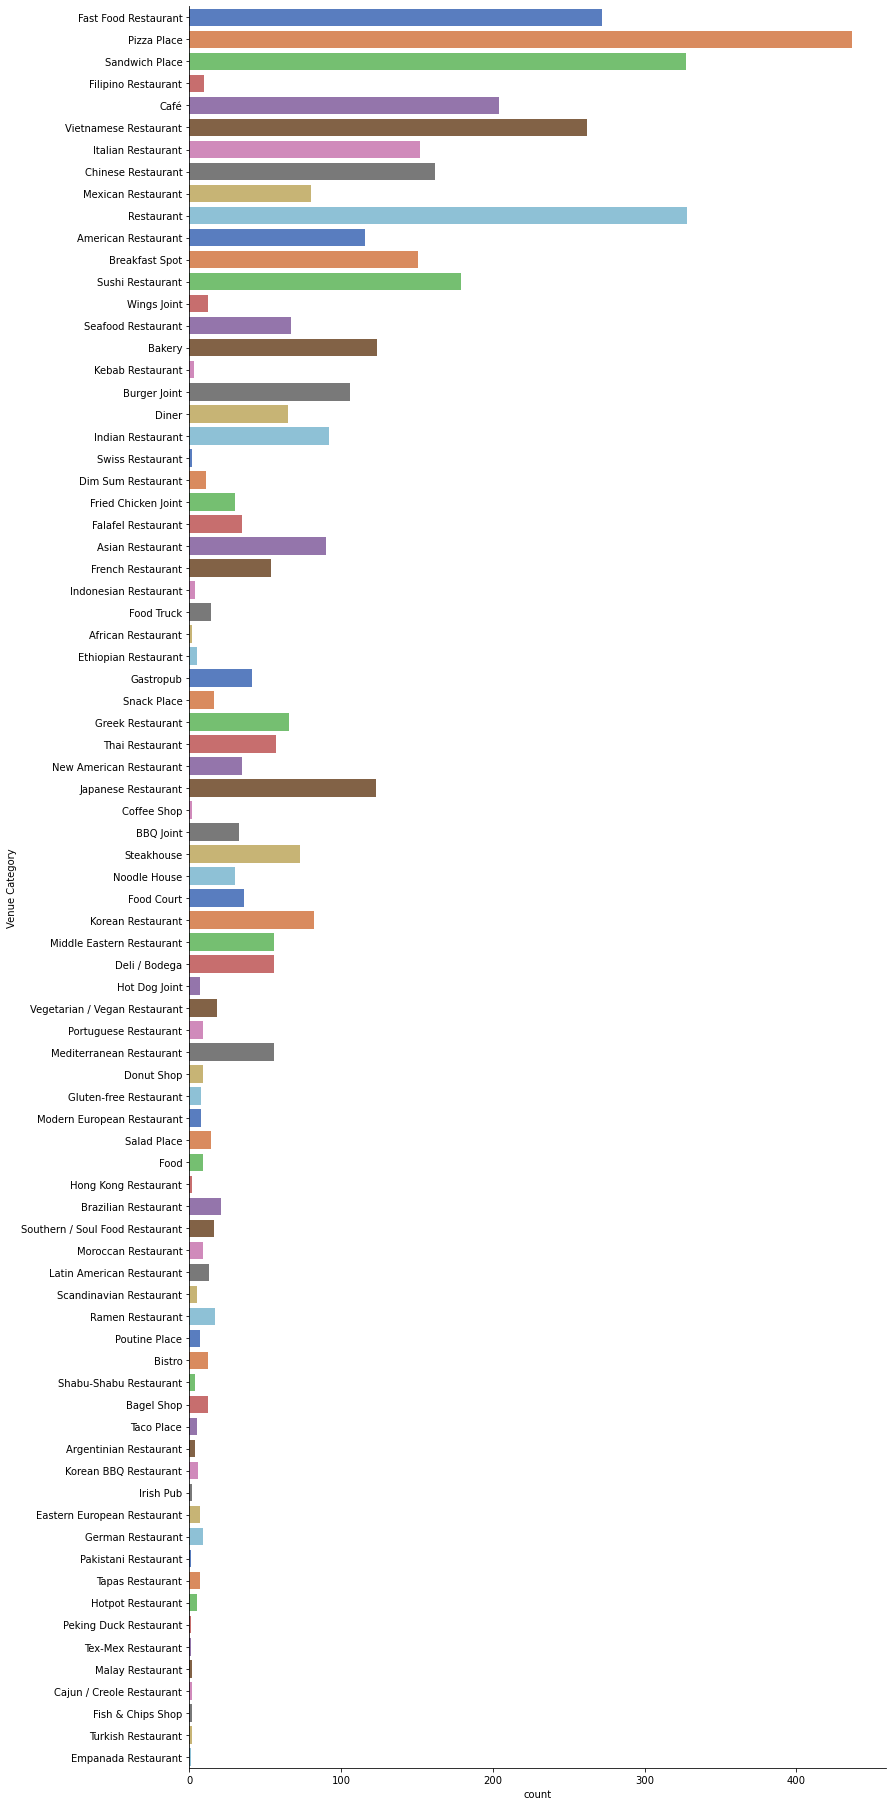

In [16]:
import seaborn as sns
sns.catplot(y='Venue Category', kind="count", height=25, orient = 'h', aspect =0.5, palette="muted", data=calVenues);

#### Food venue distribution per community

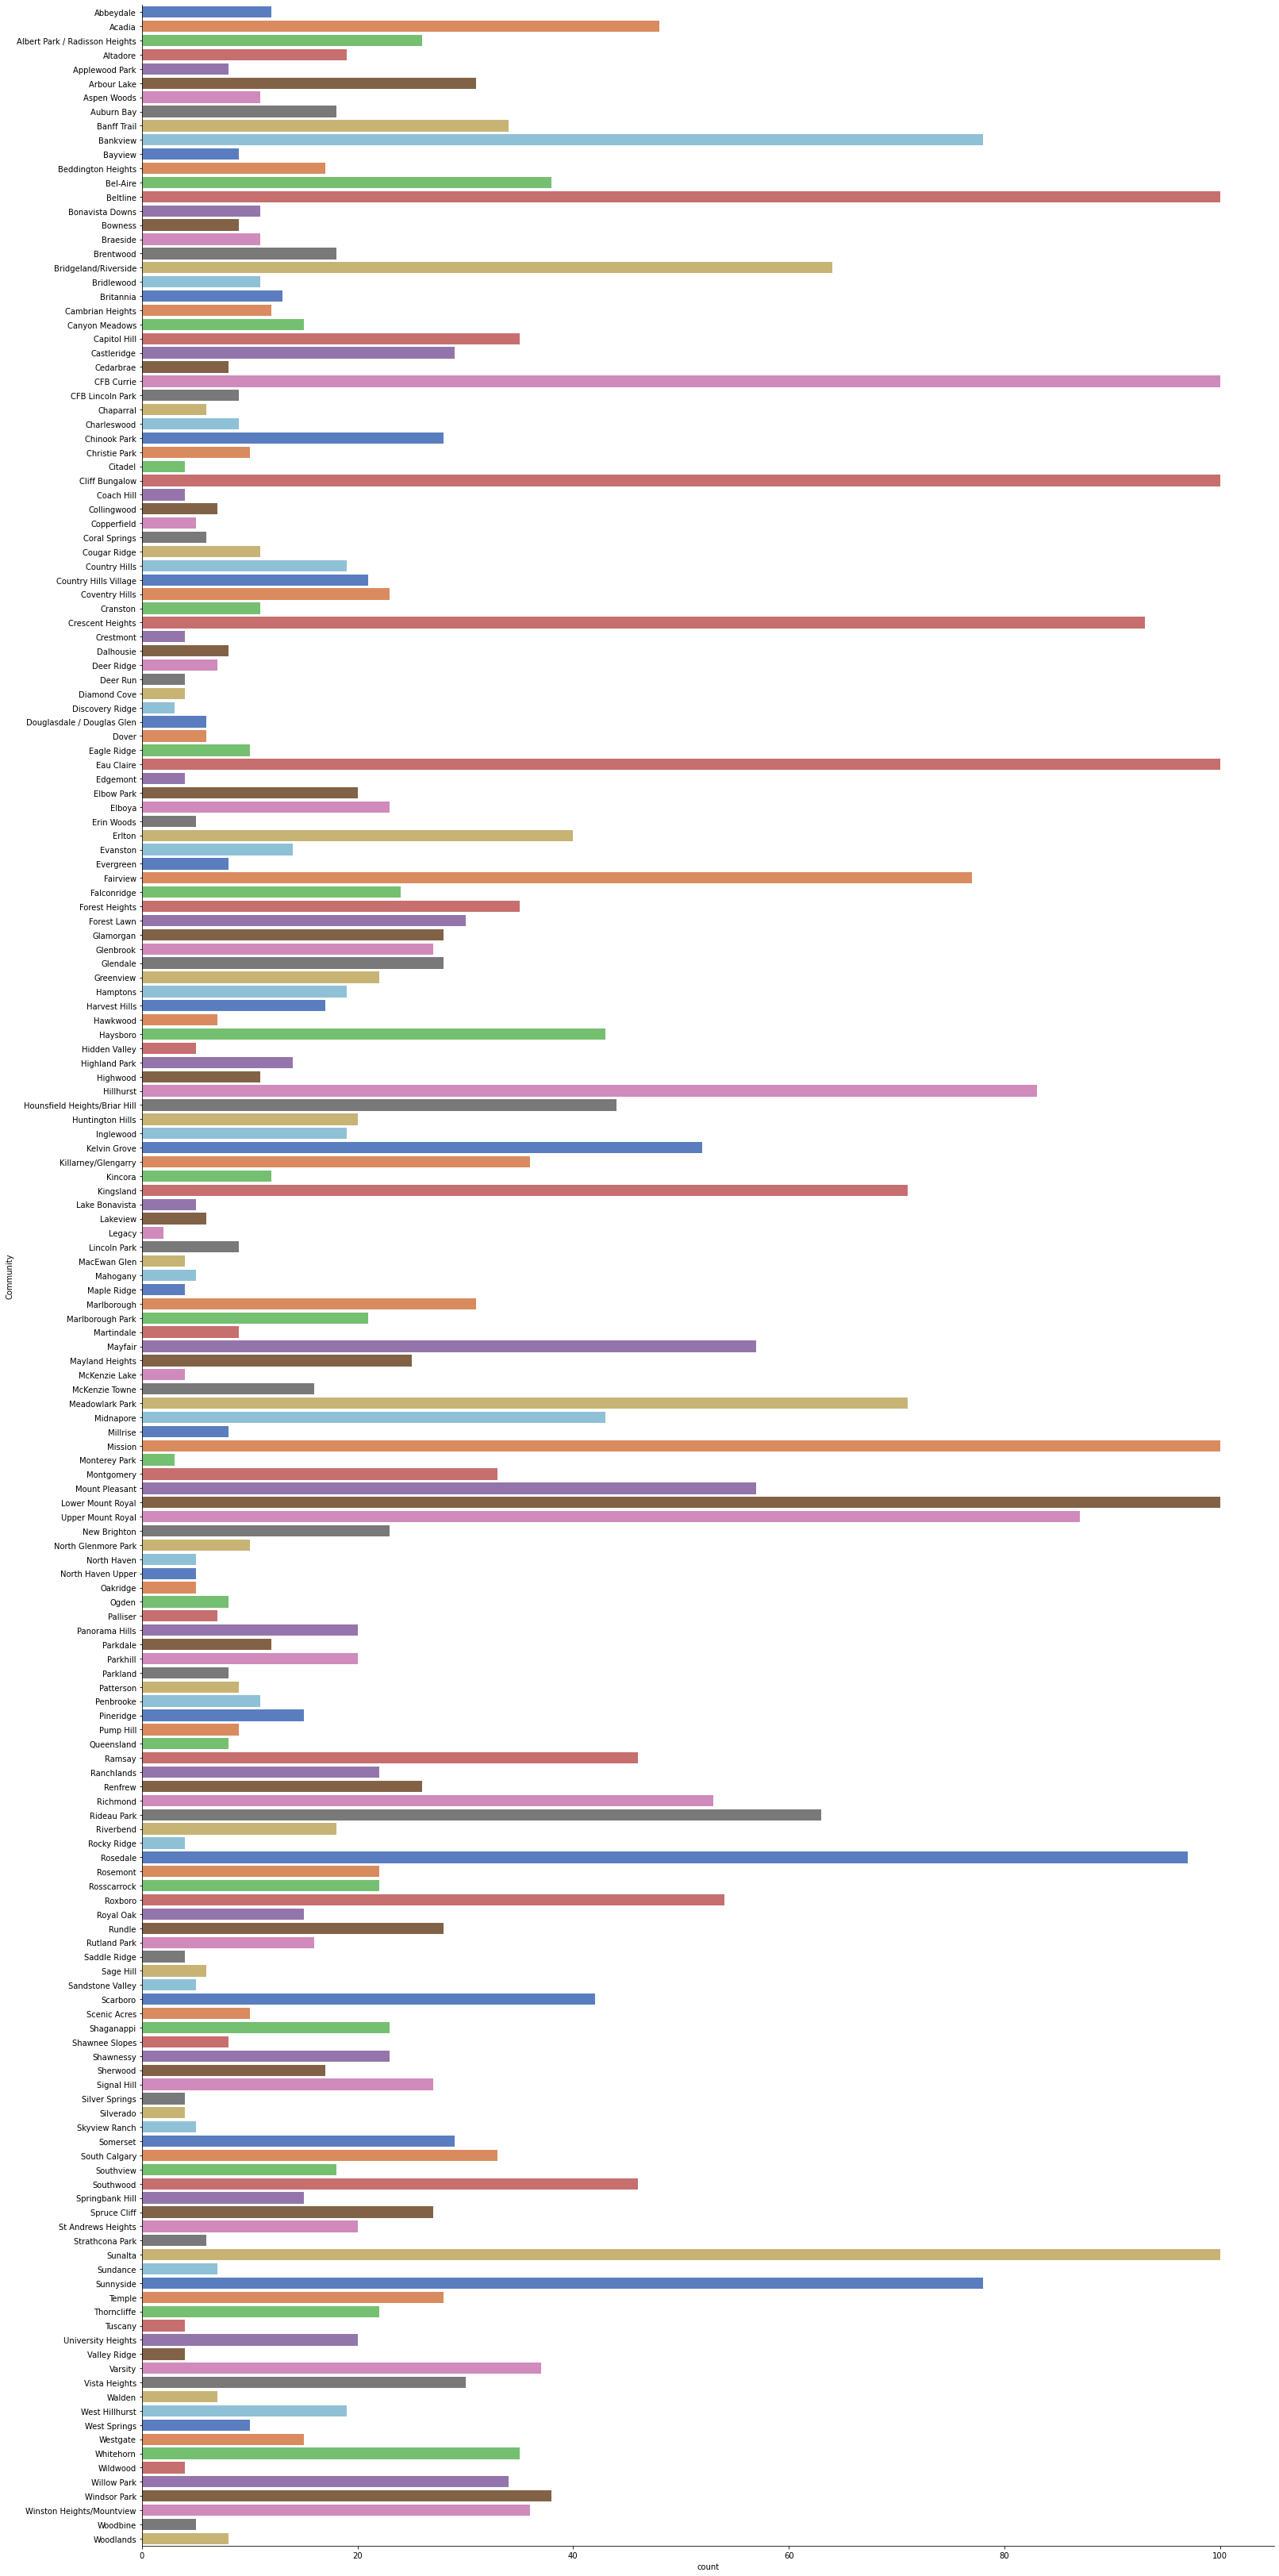

In [17]:
sns.catplot(y='Community', kind="count", height=45, orient = 'h', aspect =0.5, palette="muted", data=calVenues);

In [18]:

tt = calVenues.groupby(['Community'])['Venue'].count()
tt = pd.DataFrame(tt)
tt.columns = ['venueCount']
tt= tt.reset_index()
tt.head()

,Community,venueCount
0,Abbeydale,12
1,Acadia,48
2,Albert Park / Radisson Heights,26
3,Altadore,19
4,Applewood Park,8


In [19]:
calDF = calDF.merge(tt, on='Community', how='left')
calDF.head()

,Community,Median Household Income,Population,Area,PopulationDensity,Latitude,Longitude,venueCount
0,Abbeydale,55345.0,6071,1.7,3571.176471,51.05976,-113.92546,12.0
1,Acadia,46089.0,10969,3.9,2812.564103,50.97227,-114.05882,48.0
2,Albert Park / Radisson Heights,38019.0,6529,2.5,2611.600000,51.04200,-113.99683,26.0
3,Altadore,53786.0,9518,2.9,3282.068966,51.01601,-114.10558,19.0
4,Applewood Park,65724.0,6864,1.6,4290.000000,51.04544,-113.92513,8.0


#### One hot encoding

In [20]:
# one hot encoding
cal_onehot = pd.get_dummies(calVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cal_onehot['Community'] = calVenues['Community'] 

# move neighborhood column to the first column
fixed_columns = [cal_onehot.columns[-1]] + list(cal_onehot.columns[:-1])
cal_onehot = cal_onehot[fixed_columns]

cal_onehot.head()


,Community,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Abbeydale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abbeydale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abbeydale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abbeydale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abbeydale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
cal_grouped = cal_onehot.groupby('Community').mean().reset_index()
cal_grouped.head()

,Community,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Abbeydale,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.083333,0.000000
1,Acadia,0.000000,0.0625,0.0,0.020833,0.0,0.0,0.041667,0.0,0.0,...,0.041667,0.020833,0.0,0.0,0.0,0.000000,0.0,0.0,0.104167,0.020833
2,Albert Park / Radisson Heights,0.038462,0.0000,0.0,0.076923,0.0,0.0,0.038462,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.153846,0.000000
3,Altadore,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.157895,0.000000,0.0,0.0,0.0,0.052632,0.0,0.0,0.052632,0.000000
4,Applewood Park,0.000000,0.0000,0.0,0.125000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.250000,0.000000


#### 3. Feature Engineering

In [22]:

calRestDF_feat = calDF[['Community','Median Household Income','PopulationDensity','venueCount']]
calRestDF_feat = calRestDF_feat.merge(cal_grouped[['Community','Chinese Restaurant','Japanese Restaurant','Sushi Restaurant','Dim Sum Restaurant']],on='Community', how='left')
calRestDF_feat.head()

,Community,Median Household Income,PopulationDensity,venueCount,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Dim Sum Restaurant
0,Abbeydale,55345.0,3571.176471,12.0,0.083333,0.0,0.000000,0.000000
1,Acadia,46089.0,2812.564103,48.0,0.020833,0.0,0.041667,0.020833
2,Albert Park / Radisson Heights,38019.0,2611.600000,26.0,0.000000,0.0,0.000000,0.000000
3,Altadore,53786.0,3282.068966,19.0,0.052632,0.0,0.157895,0.000000
4,Applewood Park,65724.0,4290.000000,8.0,0.000000,0.0,0.000000,0.000000


In [23]:
calRestDF_feat.fillna(0.0,inplace=True)

In [24]:
calRestDF_feat.isna().sum()

Community                  0
Median Household Income    0
PopulationDensity          0
venueCount                 0
Chinese Restaurant         0
Japanese Restaurant        0
Sushi Restaurant           0
Dim Sum Restaurant         0
dtype: int64

### 4. Clustering and analysis

#### 4.1 Scale data using MinMax scaler

In [25]:
from sklearn.preprocessing import MinMaxScaler

# scale all features
calRestDF_scaled = calRestDF_feat.drop('Community', axis =1)
calRestDF_scaled = (calRestDF_scaled - calRestDF_scaled.min())/(calRestDF_scaled.max() - calRestDF_scaled.min())
calRestDF_scaled.head()

,Median Household Income,PopulationDensity,venueCount,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Dim Sum Restaurant
0,0.161939,0.319253,0.12,0.208333,0.0,0.000000,0.000
1,0.101824,0.250325,0.48,0.052083,0.0,0.166667,0.375
2,0.049412,0.232065,0.26,0.000000,0.0,0.000000,0.000
3,0.151813,0.292985,0.19,0.131579,0.0,0.631579,0.000
4,0.229347,0.384566,0.08,0.000000,0.0,0.000000,0.000


In [26]:
calRestDF_scaled.isna().sum()

Median Household Income    0
PopulationDensity          0
venueCount                 0
Chinese Restaurant         0
Japanese Restaurant        0
Sushi Restaurant           0
Dim Sum Restaurant         0
dtype: int64

#### 4.2 Find K using Elbow method

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of K.

We now demonstrate the given method using the K-Means clustering technique using the Sklearn library of python.

We now define the following:

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
Inertia: It is the sum of squared distances of samples to their closest cluster center.
We iterate the values of k from 1 to 12 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

Building the clustering model and calculating the values of the Distortion and Inertia. 

In [27]:
distortions = [] 
inertias = [] 
K = range(1,12) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(calRestDF_scaled) 
    kmeanModel.fit(calRestDF_scaled)     
      
    distortions.append(sum(np.min(cdist(calRestDF_scaled, kmeanModel.cluster_centers_,'euclidean'),axis=1)) / calRestDF_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    

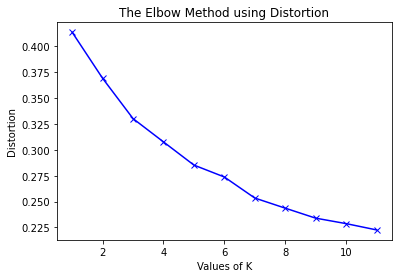

In [30]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

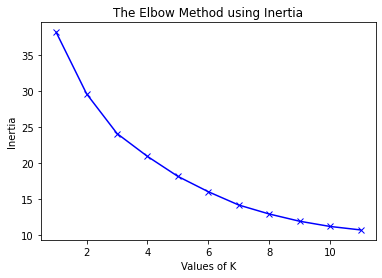

In [29]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


To determine the optimal number of clusters, we have to select the value of k at the “elbow”, where the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 5. 

#### 4.3 Clustering using K-Means

In [31]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(calRestDF_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 0, 1, 2, 2, 0, 4])

In [33]:
labelDF = pd.DataFrame(kmeans.labels_, columns=['label_'])

In [34]:
labelDF.shape

(180, 1)

#### 4.4 Visualizing the clustering result

In [35]:
# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]


#### 1. Show the clustering graph

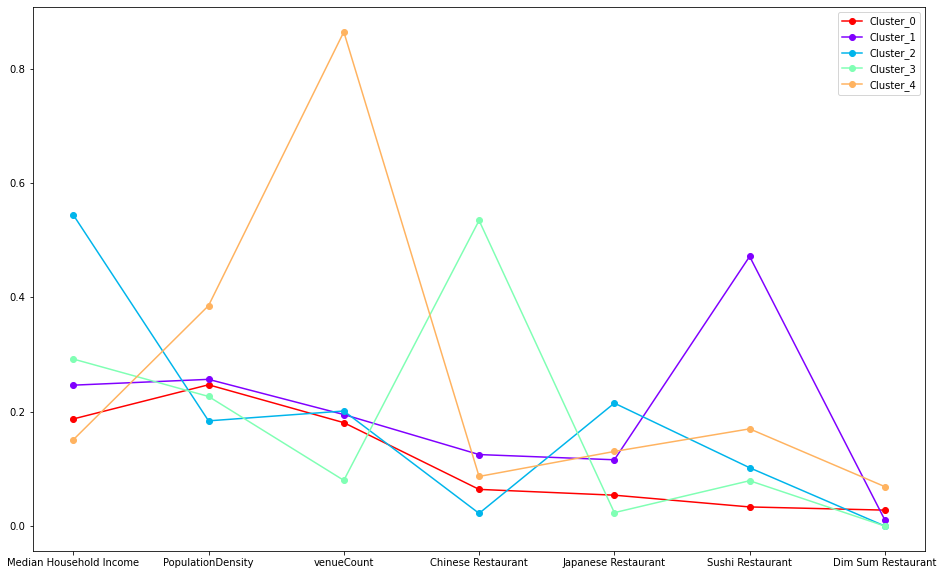

In [36]:
# plot 5 clusters and its overall characteristics

plt_DF = calRestDF_scaled.join(labelDF)

plt_DF = plt_DF.groupby('label_').mean()
plt_DF = plt_DF.T
plt_DF.columns = ['cluster_'+ str(i) for i in range(0,kclusters)]

#Plot the cluster graph
plt.figure(figsize=(16,10))

for i in range(0, kclusters):
    plt.plot(plt_DF[['cluster_'+str(i)]],color=rainbow[i-1], marker='o', label = 'Cluster_'+ str(i))
plt.legend(loc='best')
#plt.xticks(rotation=90)
plt.show()



In [38]:
resultDF = calDF.join(labelDF)
resultDF.head()

,Community,Median Household Income,Population,Area,PopulationDensity,Latitude,Longitude,venueCount,label_
0,Abbeydale,55345.0,6071,1.7,3571.176471,51.05976,-113.92546,12.0,0
1,Acadia,46089.0,10969,3.9,2812.564103,50.97227,-114.05882,48.0,0
2,Albert Park / Radisson Heights,38019.0,6529,2.5,2611.600000,51.04200,-113.99683,26.0,0
3,Altadore,53786.0,9518,2.9,3282.068966,51.01601,-114.10558,19.0,1
4,Applewood Park,65724.0,6864,1.6,4290.000000,51.04544,-113.92513,8.0,0


#### 2. Cummunity distribution per cluster

In [39]:
resultDF['label_'].value_counts()

0    85
1    37
2    23
4    18
3    17
Name: label_, dtype: int64

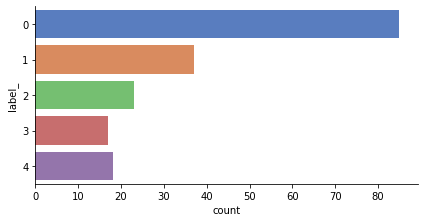

In [48]:
sns.catplot(y='label_', kind="count", height=3, orient = 'h', aspect =2, palette="muted", data=resultDF);

#### 3 Show it on the map

In [49]:
calLat = 51.0447
calLng = -114.0719

# create map
map_clusters = folium.Map(location=[calLat, calLng], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(resultDF['Latitude'], resultDF['Longitude'], resultDF['Community'], resultDF['label_']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters